In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

Tlist = [1.0]
from matplotlib.pyplot import cm
clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}

/tmp/ipykernel_2964179/1561577914.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]


In [3]:


def read_kernel(dirname, elempair):
    filename = os.path.join(dirname, "s0-Sk-"+elempair+"-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s011,covs011 = tuple([float(x) for x in fp.readline().split()[1:]])
    return s011, covs011


In [4]:
def read_lammpstrj(filedesc):
    # three comment lines
    for i in range(3): comment = filedesc.readline()
    # number of atoms
    natoms = int(filedesc.readline())

    # 1 comment line
    comment = filedesc.readline()
    # assume orthorombic cell
    cell = np.zeros(3,float)
    for i in range(3):
        # [cellmin, cellmax] = filedesc.readline().split()
        linec = filedesc.readline().split()
        cellmin = linec[0]
        cellmax = linec[1]
        cell[i] = float(cellmax) - float(cellmin)

    # 1 comment line
    comment = filedesc.readline()
    names = np.zeros(natoms,'U2')
    q = np.zeros((natoms,3),float)
    sq = np.zeros((natoms,3),float)

    for i in range(natoms):
        line = filedesc.readline().split();
        names[i] = line[1] # atom type
        q[i] = line[2:5] # wrapped atomic coordinates
        sq[i,0] = float(q[i,0])/cell[0] # scaled atomic coordinates
        sq[i,1] = float(q[i,1])/cell[1] # scaled atomic coordinates
        sq[i,2] = float(q[i,2])/cell[2] # scaled atomic coordinates
    return [cell, names, sq]

In [5]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [6]:
def cofactor(B):
    return (np.linalg.inv(B)).T * np.linalg.det(B)


In [7]:
def fillDmat(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = np.eye(rank)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

def fillDmat_(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = torch.eye(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

In [8]:
def fillapproxGmat(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-np.eye(rank,rank)/0.04
    return Gmat

def fillapproxGmat_(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-torch.eye(rank,rank).to(torch.float64)/0.04
    return Gmat

In [9]:
def KBI_mu(x_, Smat_, elem=0, static_rank=2):
    rank = x_.shape[0]
    Smat_ = Smat_.reshape(rank, rank)
    approx_Gmat = fillapproxGmat_(Smat_)

    # print("Approximate Gmat = ", approx_Gmat[0,0], approx_Gmat[1,1], approx_Gmat[0,1], approx_Gmat[1,0])
    # Smat_ = torch.from_numpy(Smat).requires_grad_()
    
    # Gmat = fillGmat(c, Smat)
    # Bmat = fillBmat(c, Gmat)
    # Dmat = fillDmat(x,Smat)
    
    Dmat_ = fillDmat_(x_,Smat_)
    print("Dmat = ", Dmat_)
    print("det(Dmat) = ", torch.linalg.det(Dmat_))
    # tiDmat = np.linalg.inv(Dmat).T
    tiDmat_ = torch.linalg.inv(Dmat_).T
    print("tiDmat = ", tiDmat_)
    # Kai_NPT = np.zeros([rank,rank])
    Kai_NPT_ = torch.zeros([rank,rank], dtype=torch.float64)
    # x_ = torch.from_numpy(x).requires_grad_()
    for i in range(rank):
        for j in range(rank):
            s1 = 0.0
            s2 = 0.0
            s3 = 0.0
            for k in range(rank):
                s1 += tiDmat_[k][i]
                s2 += tiDmat_[k][j]
                for h in range(rank):
                    s3 += x_[h]*tiDmat_[k][h]
            Kai_NPT_[i][j] = tiDmat_[i][j]/x_[i] - s1*s2/s3
    print("Kai_NPT_N*N     = ",Kai_NPT_)
    Kai_NPT_lnx_ = torch.zeros(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if j == static_rank:
                continue
            print(i,j)
            if i==j: 
                Kai_NPT_lnx_[i] += Kai_NPT_[i][i]*x_[i]
            else:
                Kai_NPT_lnx_[i] -= Kai_NPT_[i][j]*x_[i]
            
    # print("Kai_NPT_lnx = ", Kai_NPT_lnx_)
    
    # Kai_NPT_00_a = 1./(x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1])  
    # print("!!!!!! checking:: ", (x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1]), Kai_NPT_00_a) 
    # assert math.isclose(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy(), abs_tol =  1e-4)
    return Kai_NPT_lnx_[elem], Kai_NPT_

In [10]:
frac_3 = 0.05
frac_1 = np.array([ 0.10, 0.20, 0.25, 0.30, 0.35, 0.45, 0.50, 0.60, 0.65, 0.70, 0.75, 0.85])
frac_2 = 1-frac_3-frac_1
molfrac_list=[[frac_1[i], frac_2[i], frac_3] for i in range(len(frac_1))]
print(molfrac_list)


[[0.1, 0.85, 0.05], [0.2, 0.75, 0.05], [0.25, 0.7, 0.05], [0.3, 0.6499999999999999, 0.05], [0.35, 0.6, 0.05], [0.45, 0.49999999999999994, 0.05], [0.5, 0.44999999999999996, 0.05], [0.6, 0.35, 0.05], [0.65, 0.29999999999999993, 0.05], [0.7, 0.25, 0.05], [0.75, 0.19999999999999996, 0.05], [0.85, 0.09999999999999998, 0.05]]


In [11]:
Kai_NPT_lnx_list = []
Kai_NPT_lnx1_list = []
std_Kai_NPT_lnx_list = []
# order2_std_Kai_NPT_lnx_list = []
s0_list = []
N_Kai_NPT_N_list = []
for idx_T, T in enumerate(Tlist):
    Kai_NPT_lnx_list.append([])
    Kai_NPT_lnx1_list.append([])
    std_Kai_NPT_lnx_list.append([])
    s0_list.append([])

    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
        dirname = "A%.2fB%.2f/"%(molfrac_list[idx_molfrac_][0], molfrac_list[idx_molfrac_][1])
        s011, cov_s011 = read_kernel(dirname, "11")
        s012, cov_s012 = read_kernel(dirname, "12")
        s022, cov_s022 = read_kernel(dirname, "22")
        s013, cov_s013 = read_kernel(dirname, "13")
        s023, cov_s023 = read_kernel(dirname, "23")
        s033, cov_s033 = read_kernel(dirname, "33")




        x = molfrac_
        print("Mole fraction of atoms in the system =",x)


        Smat = np.array([[s011, s012, s013], [s012, s022, s023], [s013, s023, s033]])
        s0_list[-1].append(Smat)
        std_Smat = np.sqrt(np.array([cov_s011, cov_s012, cov_s013, cov_s012, cov_s022, cov_s023, cov_s013, cov_s023, cov_s033]))
        print("   Smat = ")
        print(Smat)
        varmat_Smat = np.outer(std_Smat, std_Smat)
        # print("varmat_Smat = ")
        # print(varmat_Smat)

        Smat_ = torch.from_numpy(Smat.reshape(-1)).to(dtype=torch.float64).requires_grad_()
        x_ = torch.tensor(x).to(torch.float64).requires_grad_(False)
        
        Kai_NPT_lnx_0, N_Kai_NPT_N = KBI_mu(x_, Smat_, 0)
        Kai_NPT_lnx_1, N_Kai_NPT_N = KBI_mu(x_, Smat_, 1)
        N_Kai_NPT_N_list.append(N_Kai_NPT_N.detach().numpy())
        print("Kai_NPT_lnx = ", Kai_NPT_lnx_0.detach().numpy(), Kai_NPT_lnx_1.detach().numpy())
        # jac = jacobian(KBI_mu, (x_, Smat_.reshape(-1)))[1]
        # print("Jac = ")
        # print(jac)
        varmat_Smat_ = torch.from_numpy(varmat_Smat)
        # varmat_KaiNPT_lnx = torch.matmul(torch.matmul(jac, varmat_Smat_), jac.T)
        
        # print("          var_KaiNPT_lnx = ", varmat_KaiNPT_lnx)
        # print("2nd order var_KaiNPT_lnx = ", order2_varmat_KaiNPT_lnx)
        # std_KaiNPT_lnx = torch.sqrt(varmat_KaiNPT_lnx)
        # print("          std_KaiNPT_lnx = ", std_KaiNPT_lnx)
        Kai_NPT_lnx_list[-1].append(Kai_NPT_lnx_0.detach().numpy())
        Kai_NPT_lnx1_list[-1].append(Kai_NPT_lnx_1.detach().numpy())
        # std_Kai_NPT_lnx_list[-1].append(std_KaiNPT_lnx.detach().numpy())
        print("\n")
        

Mole fraction of atoms in the system = [0.1, 0.85, 0.05]
   Smat = 
[[ 0.90960759 -0.29269231 -0.07945301]
 [-0.29269231  0.17066153 -0.19720369]
 [-0.07945301 -0.19720369  0.95521824]]
Dmat =  tensor([[ 0.9096, -0.8533, -0.0562],
        [-0.1004,  0.1707, -0.0478],
        [-0.1124, -0.8131,  0.9552]], dtype=torch.float64,
       grad_fn=<CopySlices>)
det(Dmat) =  tensor(0.0208, dtype=torch.float64, grad_fn=<LinalgDetBackward0>)
tiDmat =  tensor([[ 5.9599,  4.8624,  4.8400],
        [41.3301, 41.4145, 40.1141],
        [ 2.4200,  2.3597,  3.3401]], dtype=torch.float64,
       grad_fn=<PermuteBackward0>)
Kai_NPT_N*N     =  tensor([[ 8.8858, -0.9943, -0.8691],
        [-0.9943,  0.1765, -1.0117],
        [-0.8691, -1.0117, 18.9367]], dtype=torch.float64,
       grad_fn=<CopySlices>)
0 0
0 1
1 0
1 1
2 0
2 1
Dmat =  tensor([[ 0.9096, -0.8533, -0.0562],
        [-0.1004,  0.1707, -0.0478],
        [-0.1124, -0.8131,  0.9552]], dtype=torch.float64,
       grad_fn=<CopySlices>)
det(Dmat) = 

(1, 12, 3, 3)


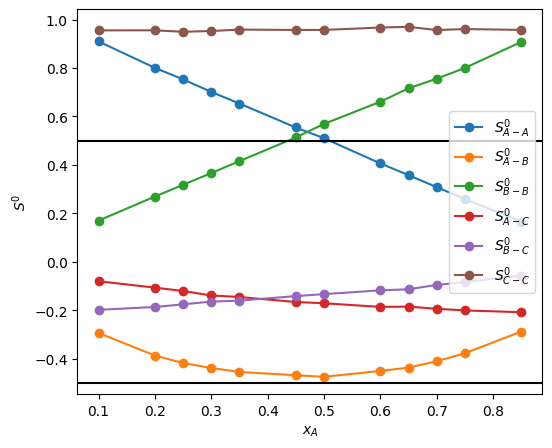

In [12]:
xlist = []
for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
    xlist.append(molfrac_[0])

s0_list = np.array(s0_list)
print(s0_list.shape)

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(xlist, s0_list[0,:,0,0], marker="o", label="$S^0_{A-A}$")
plt.plot(xlist, s0_list[0,:,0,1], marker="o", label="$S^0_{A-B}$")
plt.plot(xlist, s0_list[0,:,1,1], marker="o", label="$S^0_{B-B}$")
plt.plot(xlist, s0_list[0,:,0,2], marker="o", label="$S^0_{A-C}$")
plt.plot(xlist, s0_list[0,:,1,2], marker="o", label="$S^0_{B-C}$")
plt.plot(xlist, s0_list[0,:,2,2], marker="o", label="$S^0_{C-C}$")
plt.axhline(0.5, c="k")
plt.axhline(-0.5, c="k")
plt.xlabel("$x_A$")
plt.ylabel("$S^0$")
plt.legend()

In [13]:
d_list = []
for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
    x = molfrac_
    print("Mole fraction of atoms in the system =",x)
    Smat = s0_list[-1][idx_molfrac_]
    Dmat = fillDmat(x, Smat)
    tiDmat = np.linalg.inv(Dmat).T
    d_list.append(tiDmat)
d_list = np.array(d_list)

Mole fraction of atoms in the system = [0.1, 0.85, 0.05]
Mole fraction of atoms in the system = [0.2, 0.75, 0.05]
Mole fraction of atoms in the system = [0.25, 0.7, 0.05]
Mole fraction of atoms in the system = [0.3, 0.6499999999999999, 0.05]
Mole fraction of atoms in the system = [0.35, 0.6, 0.05]
Mole fraction of atoms in the system = [0.45, 0.49999999999999994, 0.05]
Mole fraction of atoms in the system = [0.5, 0.44999999999999996, 0.05]
Mole fraction of atoms in the system = [0.6, 0.35, 0.05]
Mole fraction of atoms in the system = [0.65, 0.29999999999999993, 0.05]
Mole fraction of atoms in the system = [0.7, 0.25, 0.05]
Mole fraction of atoms in the system = [0.75, 0.19999999999999996, 0.05]
Mole fraction of atoms in the system = [0.85, 0.09999999999999998, 0.05]


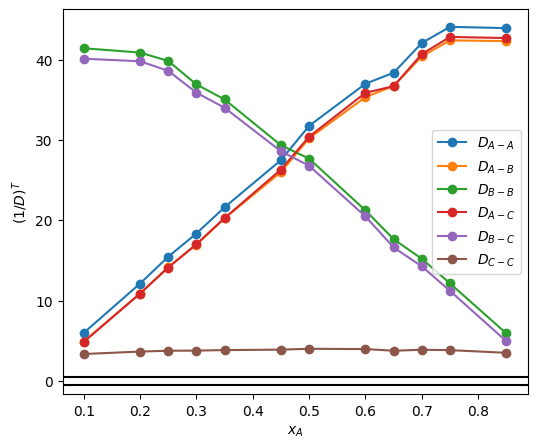

In [14]:

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(xlist, d_list[:,0,0], marker="o", label="$D_{A-A}$")
plt.plot(xlist, d_list[:,0,1], marker="o", label="$D_{A-B}$")
plt.plot(xlist, d_list[:,1,1], marker="o", label="$D_{B-B}$")
plt.plot(xlist, d_list[:,0,2], marker="o", label="$D_{A-C}$")
plt.plot(xlist, d_list[:,1,2], marker="o", label="$D_{B-C}$")
plt.plot(xlist, d_list[:,2,2], marker="o", label="$D_{C-C}$")
plt.axhline(0.5, c="k")
plt.axhline(-0.5, c="k")
plt.xlabel("$x_A$")
plt.ylabel("$(1/D)^T$")
plt.legend()

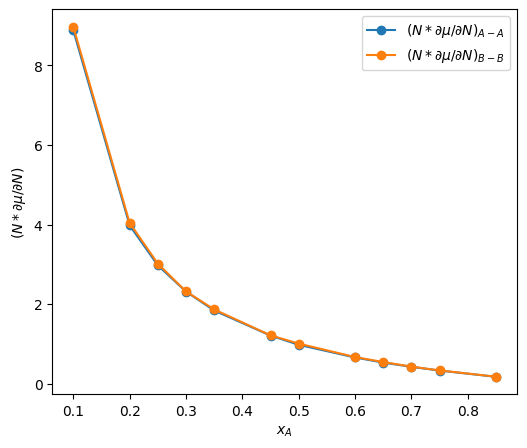

In [83]:
N_Kai_NPT_N_list = np.array(N_Kai_NPT_N_list)
plt.rcParams["figure.figsize"] = (6,5)
plt.plot(xlist, N_Kai_NPT_N_list[:,0,0], marker="o", label="$(N*\partial\mu/\partial N)_{A-A}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,0,1], marker="o", label="$(N*\partial\mu/\partial N)_{A-B}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,1,0], marker="x", label="$(N*\partial\mu/\partial N)_{B-A}$")
plt.plot(0.95-xlist, N_Kai_NPT_N_list[:,1,1], marker="o", label="$(N*\partial\mu/\partial N)_{B-B}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,0,2], marker="o", label="$(N*\partial\mu/\partial N)_{A-C}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,2,0], marker="o", label="$(N*\partial\mu/\partial N)_{C-A}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,1,2], marker="x", label="$(N*\partial\mu/\partial N)_{B-C}$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,2,2], marker="o", label="$(N*\partial\mu/\partial N)_{C-C}$")

plt.xlabel("$x_A$")
plt.ylabel("$(N*\partial\mu/\partial N)$")
plt.legend()

[9.88001992 4.97977206 3.97140292 3.31767184 2.83954874 2.20979728
 1.96344937 1.65740341 1.52180091 1.42196432 1.3323976  1.15983885]
[1.17074274 1.33296993 1.42659731 1.54650152 1.66908162 2.00787168
 2.20065142 2.86458327 3.31075847 4.01530716 5.04293151 9.95828197]
[0.1  0.2  0.25 0.3  0.35 0.45 0.5  0.6  0.65 0.7  0.75 0.85]
[0.85 0.75 0.7  0.65 0.6  0.5  0.45 0.35 0.3  0.25 0.2  0.1 ]


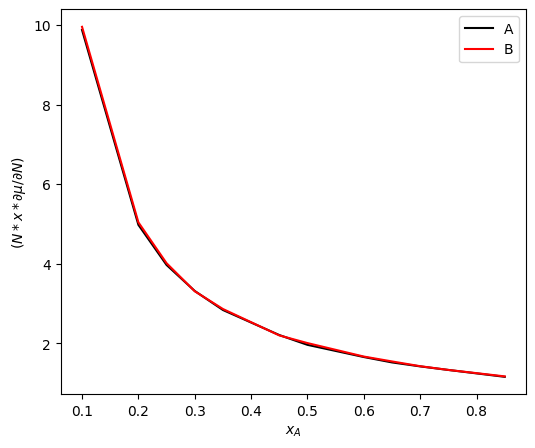

In [82]:
xlist = np.array(xlist)
plt.rcParams["figure.figsize"] = (6,5)
# plt.plot(xlist,  N_Kai_NPT_N_list[:,0,0]*xlist, marker="o", label="$(N*\partial\mu/\partial N)_{A-A}*x_A$")
# plt.plot(xlist, N_Kai_NPT_N_list[:,0,1]*(xlist), marker="o", label="$(N*\partial\mu/\partial N)_{A-B}*x_A$")
# # plt.plot(xlist, N_Kai_NPT_N_list[:,0,2]*(xlist), marker="o", label="$(V*\partial\mu/\partial N)_{A-C}*x_A$")
# 
# plt.plot(0.95-xlist,  N_Kai_NPT_N_list[:,1,1]*(0.95-xlist), marker="x", label="$(N*\partial\mu/\partial N)_{B-B}*x_B$")
# plt.plot((0.95-xlist), N_Kai_NPT_N_list[:,1,0]*(0.95-xlist), marker="x", label="$(N*\partial\mu/\partial N)_{B-A}*x_B$")
# # plt.plot(xlist, N_Kai_NPT_N_list[:,0,2]*(0.95-xlist), marker="x", label="$(V*\partial\mu/\partial N)_{B-C}*x_B$")

# # plt.scatter(xlist, Kai_NPT_lnx_list[0], marker="o", label="A", c="k")
# # plt.scatter(xlist, Kai_NPT_lnx1_list[0], marker="o", label="B", c="r")

check3 = N_Kai_NPT_N_list[:,0,0]-N_Kai_NPT_N_list[:,0,1]
check4 = N_Kai_NPT_N_list[:,1,1]-N_Kai_NPT_N_list[:,1,0]
print(check3)
print(check4)

check1 = (N_Kai_NPT_N_list[:,0,2]*xlist+N_Kai_NPT_N_list[:,1,2]*(0.95-xlist))
# print(check1)

plt.plot(xlist, check3, label="A", c="k")
plt.plot(0.95-xlist, check4, label="B", c="r")
print(xlist)
print(0.95-xlist)
plt.xlabel("$x_A$")
plt.ylabel("$(N*x*\partial\mu/\partial N)$")
plt.legend()

In [17]:
Kai_NPT_lnx_list[0] = np.array(Kai_NPT_lnx_list[0])
Kai_NPT_lnx1_list[0] = np.array(Kai_NPT_lnx1_list[0])
print(Kai_NPT_lnx_list[0].shape)
'''
import dpdata

totalatom = 23328
c_A_list = []
c_B_list = []
N_A_list = []
N_B_list = []
Tlist = [1.]
Volume_list = []
for idx_T, T in enumerate(Tlist):
    c_A_list.append([])
    c_B_list.append([])
    Volume_list.append([])
    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
        molfrac_1 = molfrac_[0]
        dirname = "binary/frac%.2f/"%(molfrac_1)
        filename = os.path.join(dirname, "thermo-lammps.dat")
        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]
        Volume = np.mean(Volume_data)
        Volume_list[-1].append(Volume)
        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")
        N_A_list.append(conf["atom_numbs"][0])
        N_B_list.append(conf["atom_numbs"][1])
        c_A = conf["atom_numbs"][0]/Volume
        c_A_list[-1].append(c_A)
        c_B = conf["atom_numbs"][1]/Volume
        c_B_list[-1].append(c_B)

        
        print(int(np.ceil(totalatom*molfrac_1)), conf["atom_numbs"][0])
        # assert int(np.ceil(totalatom*molfrac_1)) == conf["atom_numbs"][0]
        # assert int(totalatom-np.ceil(totalatom*molfrac_1)) == conf["atom_numbs"][1]
c_A_list = np.array(c_A_list)
c_B_list = np.array(c_B_list)
Volume_list = np.array(Volume_list)
N_A_list = np.array(N_A_list)
N_B_list = np.array(N_B_list)

print(c_A_list)
print(c_B_list)
print(totalatom)
assert np.allclose(c_A_list+c_B_list, totalatom/Volume_list)
'''

(12,)


'\nimport dpdata\n\ntotalatom = 23328\nc_A_list = []\nc_B_list = []\nN_A_list = []\nN_B_list = []\nTlist = [1.]\nVolume_list = []\nfor idx_T, T in enumerate(Tlist):\n    c_A_list.append([])\n    c_B_list.append([])\n    Volume_list.append([])\n    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):\n        molfrac_1 = molfrac_[0]\n        dirname = "binary/frac%.2f/"%(molfrac_1)\n        filename = os.path.join(dirname, "thermo-lammps.dat")\n        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]\n        Volume = np.mean(Volume_data)\n        Volume_list[-1].append(Volume)\n        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")\n        N_A_list.append(conf["atom_numbs"][0])\n        N_B_list.append(conf["atom_numbs"][1])\n        c_A = conf["atom_numbs"][0]/Volume\n        c_A_list[-1].append(c_A)\n        c_B = conf["atom_numbs"][1]/Volume\n        c_B_list[-1].append(c_B)\n\n        \n        print(int(np.ceil(totalatom*molfrac_1)), conf["atom_numb

In [18]:
molfrac_list = np.array(molfrac_list)

x = np.array(molfrac_list[:,0])
lnx = np.log(x).reshape(-1,1)
# lnc = np.log(c_A_list).reshape(-1,1)
x1 = molfrac_list[:,1]
lnx1 = np.log(x1).reshape(-1,1)
# lnc1 = np.log(c_B_list).reshape(-1,1)
# plt.plot(x, Volume_list[0])


In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.integrate import quad
# kernel = 1.0 * RBF(length_scale=0.005, length_scale_bounds="fixed")
kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(lnx.reshape(-1,1), Kai_NPT_lnx_list[0].reshape(-1,1))
y_gp, std_y_gp = gp.predict(lnx.reshape(-1,1), return_std=True)



kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp1 = GaussianProcessRegressor(kernel=kernel)
gp1.fit(lnx1.reshape(-1,1), Kai_NPT_lnx1_list[0].reshape(-1,1))
y_gp1, std_y_gp1 = gp1.predict(lnx1.reshape(-1,1), return_std=True)

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


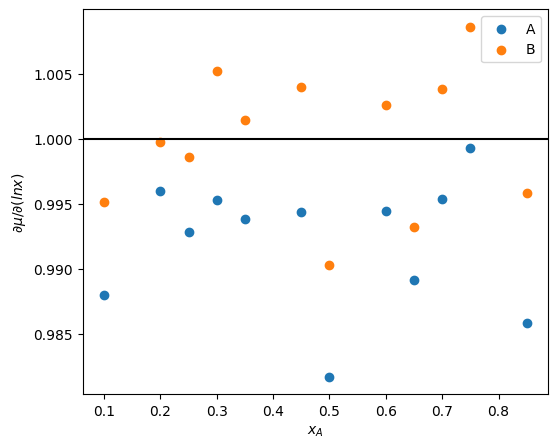

In [20]:
plt.rcParams["figure.figsize"] = (6,5)

plt.scatter(x, Kai_NPT_lnx_list[0], marker="o", label="A")
# plt.errorbar(x, Kai_NPT_lnx_list[0], std_Kai_NPT_lnx_list[0], label="A")
plt.scatter(0.95-x1, Kai_NPT_lnx1_list[0], marker="o", label="B")

plt.xlabel("$x_A$")
plt.ylabel("$\partial \mu/\partial (lnx) $")
plt.legend()
plt.axhline(1, c="k")


In [21]:
plt.rcParams["figure.figsize"] = (6,5)
from scipy.integrate import trapz
lnx1 = lnx1.reshape(-1)
lnx = lnx.reshape(-1)


integral_gp = np.cumsum([0]+[(y_gp[i]+y_gp[i+1])/2*(lnx[i+1]-lnx[i]) for i in range(len(lnx)-2)])
integral_gp1 = np.cumsum([0]+[(y_gp1[i]+y_gp1[i+1])/2*(lnx1[i+1]-lnx1[i]) for i in range(len(lnx1)-2)])
print("x-variable::")
print(x)
print(x1)
print("lnx-variable::")
print(lnx)
print(lnx1)
print("Integrand:: ")
print(y_gp)
print(y_gp1)
print("Integral cumsum")
print(integral_gp)
print(integral_gp1)

baseline = -np.array([lnx[i]-lnx[0] for i in range(len(lnx)-1)])
baseline1 = -np.array([lnx1[i]-lnx1[0] for i in range(len(lnx1)-1)])


print("baseline")
print(baseline)
print(baseline1)

print("excess")
print((integral_gp+baseline))
print((integral_gp1+baseline1))


x-variable::
[0.1  0.2  0.25 0.3  0.35 0.45 0.5  0.6  0.65 0.7  0.75 0.85]
[0.85 0.75 0.7  0.65 0.6  0.5  0.45 0.35 0.3  0.25 0.2  0.1 ]
lnx-variable::
[-2.30258509 -1.60943791 -1.38629436 -1.2039728  -1.04982212 -0.7985077
 -0.69314718 -0.51082562 -0.43078292 -0.35667494 -0.28768207 -0.16251893]
[-0.16251893 -0.28768207 -0.35667494 -0.43078292 -0.51082562 -0.69314718
 -0.7985077  -1.04982212 -1.2039728  -1.38629436 -1.60943791 -2.30258509]
Integrand:: 
[0.98800201 0.9959544  0.99285073 0.99530154 0.99384205 0.99440877
 0.98172473 0.99444203 0.9891706  0.99537501 0.99929817 0.98586305]
[0.99513135 0.99972745 0.99861812 1.00522597 1.00144897 1.00393582
 0.99029317 1.00260414 0.99322756 1.00382678 1.00858627 0.99582821]
Integral cumsum
[0.         0.68758689 0.90948141 1.09072292 1.24403684 1.4938749
 1.59797812 1.77812702 1.85751389 1.93104921 1.99985833]
[ 0.         -0.1248414  -0.1937772  -0.26802761 -0.34833746 -0.53114989
 -0.63620639 -0.88662832 -1.04045772 -1.22251075 -1.44703925

[[]]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

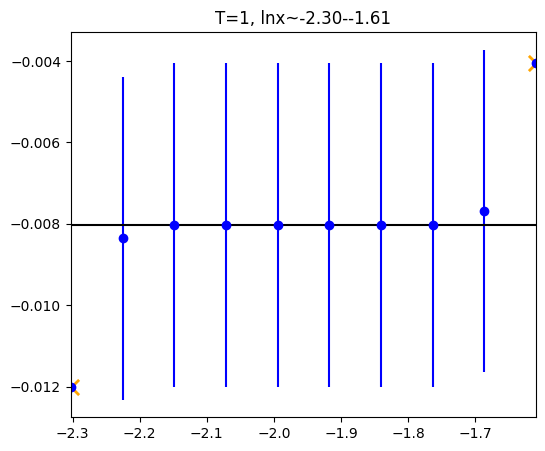

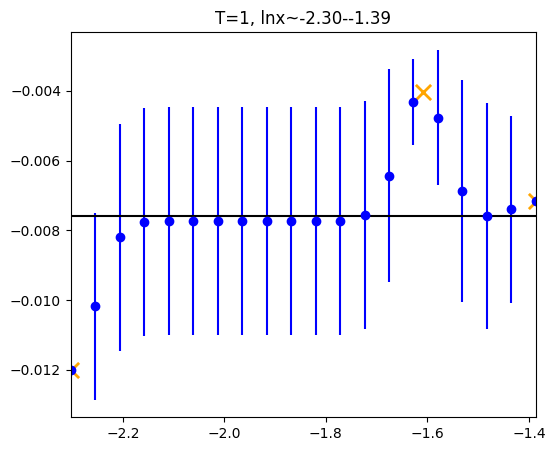

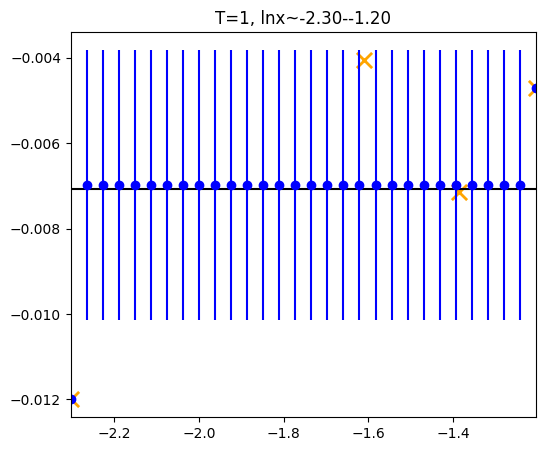

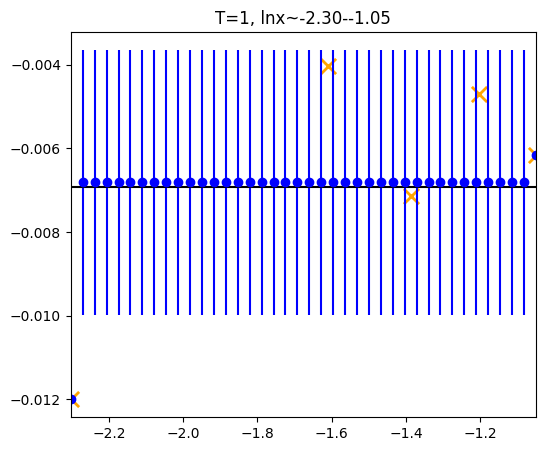

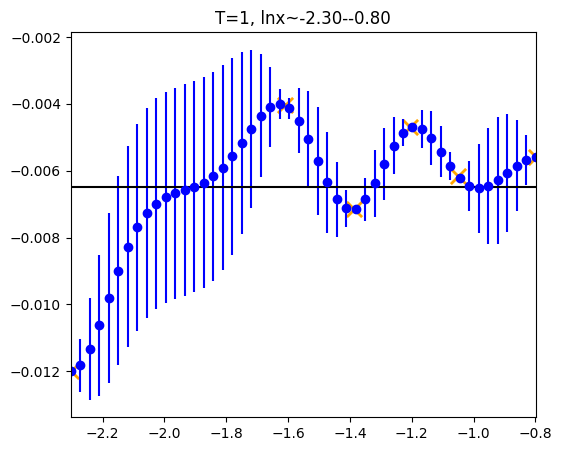

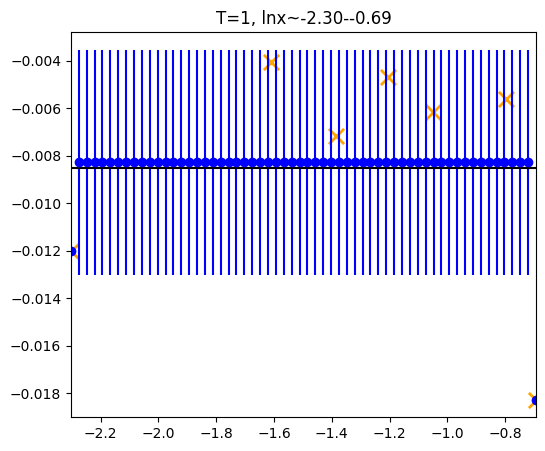

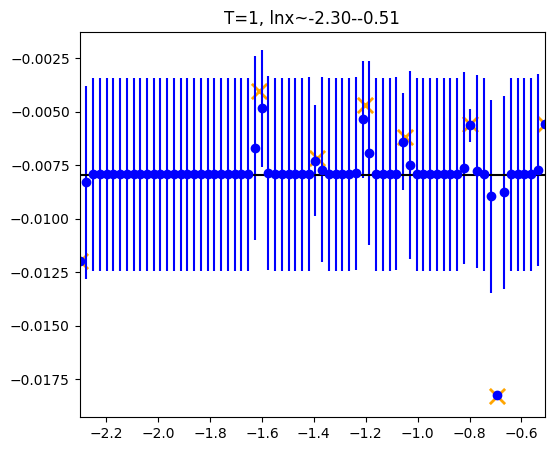

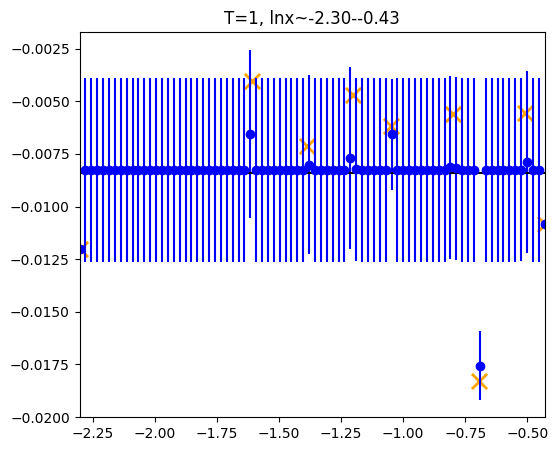

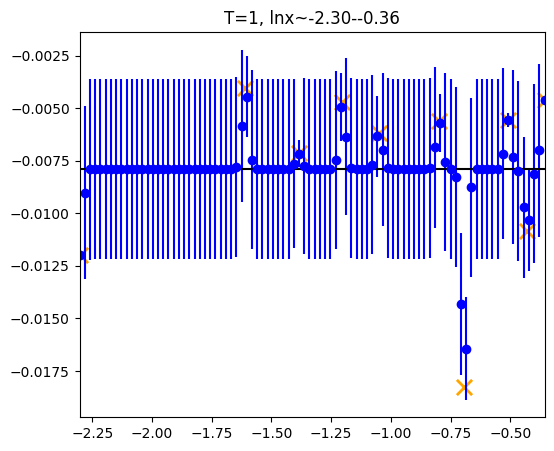

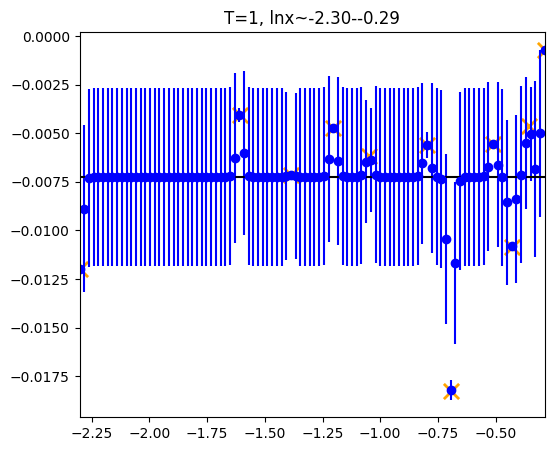

In [22]:
# integral by MC

lnx = lnx.reshape(-1)
MCintegral_gp = [0]
MCintegral_gp_std = [0]
print(std_Kai_NPT_lnx_list)

for i in range(len(lnx)-2):
    min_lnx = lnx[0]
    max_lnx = lnx[i+1]
    area_lnx = (max_lnx-min_lnx)

    MC_x_samples = np.linspace(min_lnx, max_lnx, 10*(i+1))
    mean_Kai = np.mean(Kai_NPT_lnx_list[idx_T][:i+2])
    kernel = 1.0 * RBF(length_scale=0.05*np.abs(area_lnx))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(lnx[:i+2].reshape(-1,1), Kai_NPT_lnx_list[idx_T][:i+2].reshape(-1,1)-mean_Kai)

    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    # MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i+1])/np.sqrt(100*(i+1))
    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i+1))
    MCintegral_gp.append((MC_y_average+mean_Kai)*(area_lnx))
    # print(i, area_lnx, MC_y_average+mean_Kai)
    MCintegral_gp_std.append(MC_y_std*np.abs(area_lnx))
    plt.figure()
    plt.errorbar(np.linspace(min_lnx, max_lnx, 10*(i+1)), MC_y_samples+mean_Kai, std_MC_y_samples, c="blue", fmt='o', linestyle='None')
    plt.scatter(lnx[:i+2], Kai_NPT_lnx_list[idx_T][:i+2]-1, marker="x", c="orange", s=120, linewidths=2)
    plt.axhline(MC_y_average+mean_Kai, c="k")
    plt.xlim((min_lnx, max_lnx))
    plt.title("T=%d, lnx~%.2f-%.2f"%(T, min_lnx, max_lnx))

MCintegral_gp = np.array(MCintegral_gp)
MCintegral_gp_std = np.array(MCintegral_gp_std)



[0.85 0.75 0.7  0.65 0.6  0.5  0.45 0.35 0.3  0.25 0.2  0.1 ]
[-0.16251893 -0.28768207 -0.35667494 -0.43078292 -0.51082562 -0.69314718
 -0.7985077  -1.04982212 -1.2039728  -1.38629436 -1.60943791 -2.30258509]
[0.1  0.2  0.25 0.3  0.35 0.45 0.5  0.6  0.65 0.7  0.75 0.85]
[-2.30258509 -1.60943791 -1.38629436 -1.2039728  -1.04982212 -0.7985077
 -0.69314718 -0.51082562 -0.43078292 -0.35667494 -0.28768207 -0.16251893]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

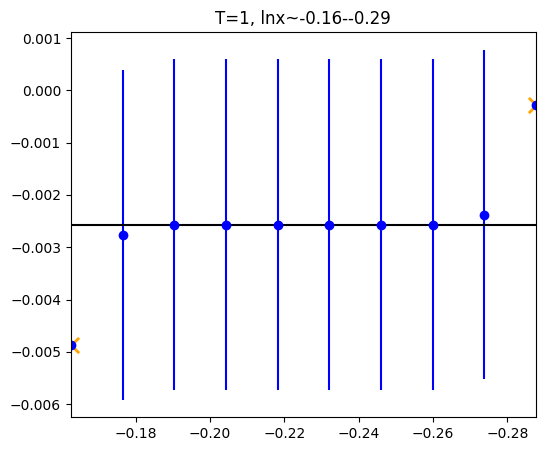

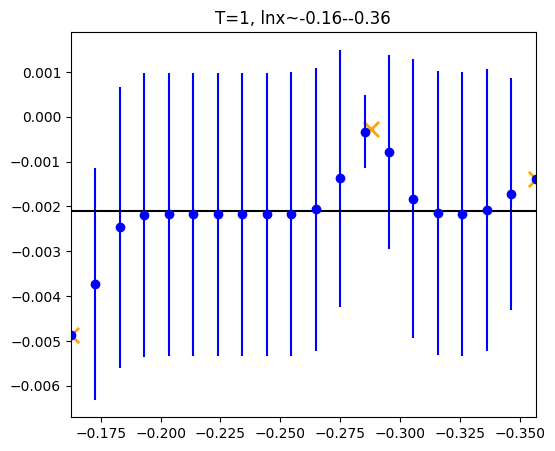

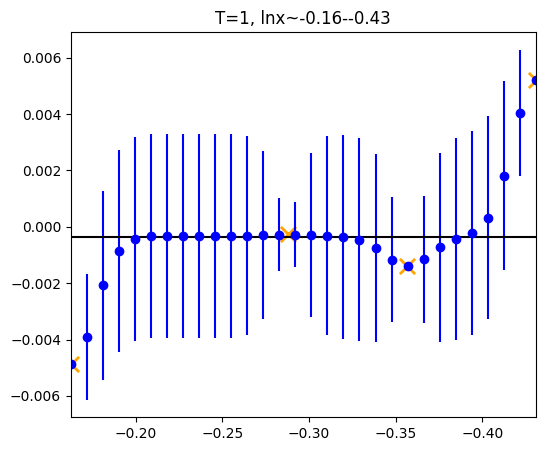

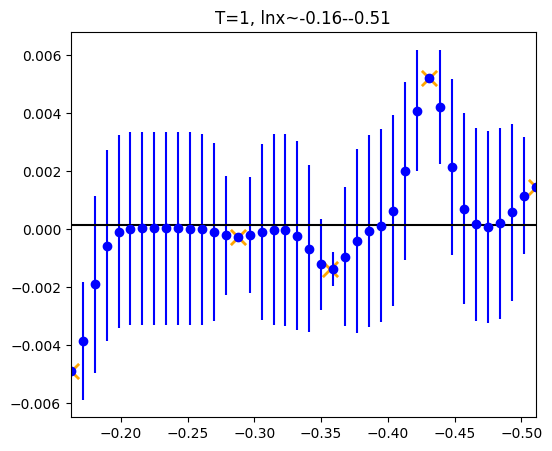

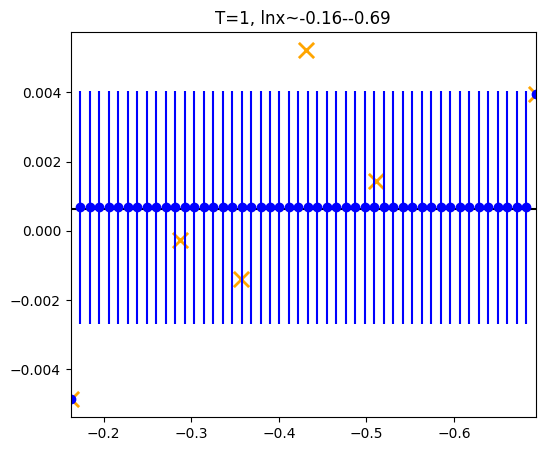

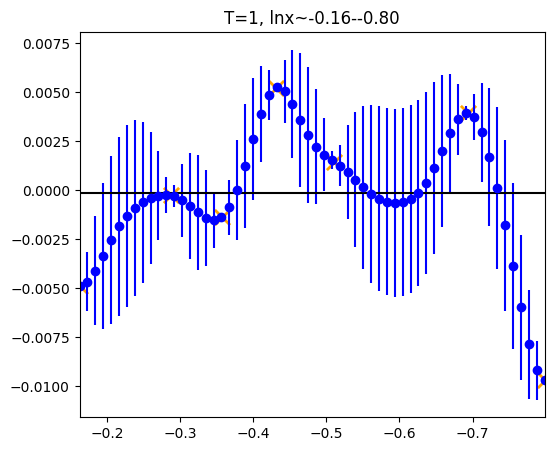

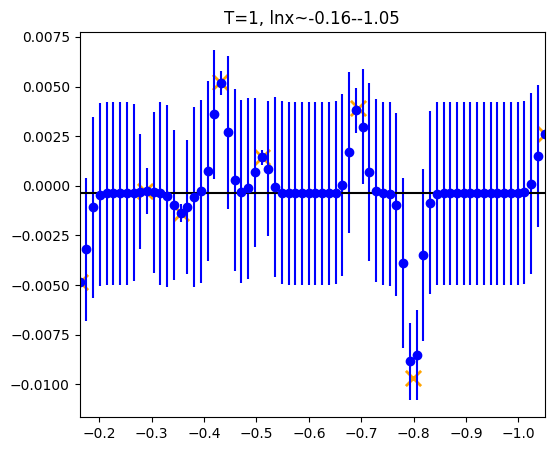

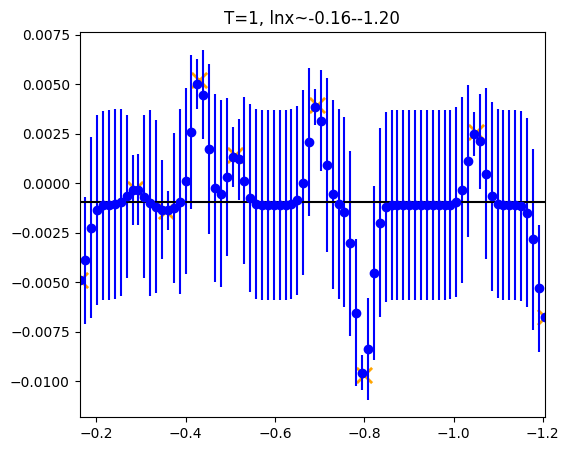

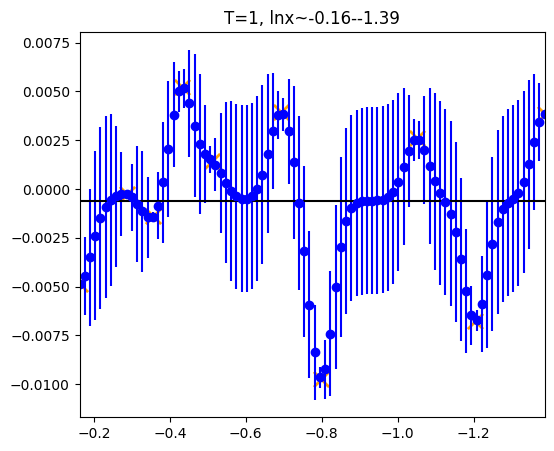

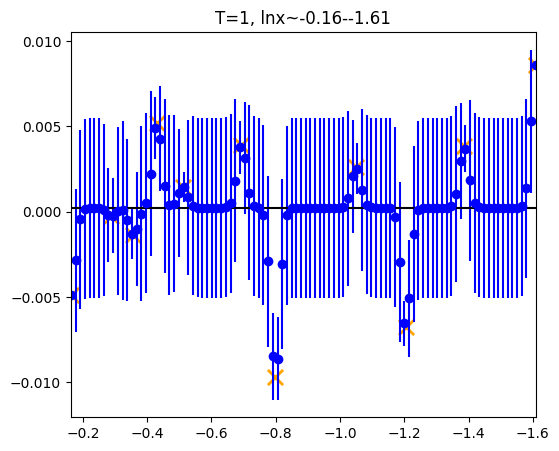

In [23]:

lnx1 = lnx1.reshape(-1)
MCintegral_gp1 = [0]
MCintegral_gp_std1 = [0]
print(x1)
print(lnx1)
print(x)
print(lnx)
for i in range(len(lnx1)-2):
    min_lnx = lnx1[0]
    max_lnx = lnx1[i+1]
    area_lnx = (max_lnx-min_lnx)
    
    MC_x_samples = np.linspace(min_lnx, max_lnx, 10*(i+1))
    mean_Kai = np.mean(Kai_NPT_lnx1_list[idx_T][:i+2])
    kernel = 1.0 * RBF(length_scale=0.05*np.abs(area_lnx))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(lnx1[:i+2].reshape(-1,1), Kai_NPT_lnx1_list[idx_T][:i+2].reshape(-1,1)-mean_Kai)
    
    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i+1))
    MCintegral_gp1.append((MC_y_average+mean_Kai)*(area_lnx))
    MCintegral_gp_std1.append(MC_y_std*np.abs(area_lnx))
    plt.figure()
    plt.errorbar(np.linspace(min_lnx, max_lnx, 10*(i+1)), MC_y_samples+mean_Kai, std_MC_y_samples, c="blue", fmt='o', linestyle='None')
    plt.scatter(lnx1[:i+2], Kai_NPT_lnx1_list[idx_T][:i+2]-1, marker="x", c="orange", s=120, linewidths=2)
    plt.axhline(MC_y_average+mean_Kai, c="k")
    plt.xlim((min_lnx, max_lnx))
    plt.title("T=%d, lnx~%.2f-%.2f"%(T, min_lnx, max_lnx))

MCintegral_gp1 = np.array(MCintegral_gp1)
MCintegral_gp_std1 = np.array(MCintegral_gp_std1)

[0.1  0.2  0.25 0.3  0.35 0.45 0.5  0.6  0.65 0.7  0.75 0.85]
[0.85 0.75 0.7  0.65 0.6  0.5  0.45 0.35 0.3  0.25 0.2  0.1 ]


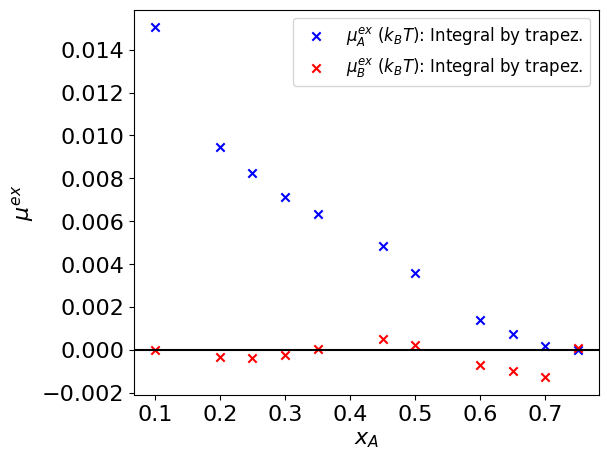

In [85]:
print(x)
print(x1)
plt.scatter(x[:-1], (integral_gp+baseline)-(integral_gp+baseline)[-1], label="$\mu^{ex}_A$ ($k_BT$): Integral by trapez.", c="blue", marker="x")
# plt.errorbar(x[:-1], MCintegral_gp-MCintegral_gp[-1], MCintegral_gp_std, color="blue", alpha=0.8, label="$\mu^{ex}_A$ ($k_BT$): Integral by MC")
plt.scatter(x[:-1], (-(integral_gp1+baseline1)+(integral_gp1+baseline1)[0]), label="$\mu^{ex}_B$ ($k_BT$): Integral by trapez.", c="red", marker="x")
# plt.errorbar(x[:-1], (-MCintegral_gp1+MCintegral_gp1[0]), (MCintegral_gp_std1), color="red", alpha=0.8, label="$\mu^{ex}_B$ ($k_BT$): Integral by MC")
# plt.fill_between(x[:-1], lowerb_MCintegral_gp, upperb_MCintegral_gp, color="blue", alpha=0.8)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}$", fontdict={"size": 16})
plt.xlabel("$x_A$", fontdict={"size": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.legend(fontsize=12)